In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-05-30 16:23:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  85.4MB/s    in 0.8s    

2020-05-30 16:23:07 (85.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.935.jpg', 'cat.227.jpg', 'cat.547.jpg', 'cat.846.jpg', 'cat.582.jpg', 'cat.618.jpg', 'cat.368.jpg', 'cat.254.jpg', 'cat.648.jpg', 'cat.501.jpg']
['dog.470.jpg', 'dog.995.jpg', 'dog.984.jpg', 'dog.55.jpg', 'dog.199.jpg', 'dog.860.jpg', 'dog.719.jpg', 'dog.620.jpg', 'dog.307.jpg', 'dog.64.jpg']


In [6]:
print('The total training cat images:', len(os.listdir(train_cats_dir)))
print('The total training dog images:', len(os.listdir(train_dogs_dir)))
print('The total validation cat images:', len(os.listdir(validation_cats_dir)))
print('The total validation dog images:', len(os.listdir(validation_dogs_dir)))

The total training cat images: 1000
The total training dog images: 1000
The total validation cat images: 500
The total validation dog images: 500


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
nrows = 4
ncols = 4
pic_index = 0

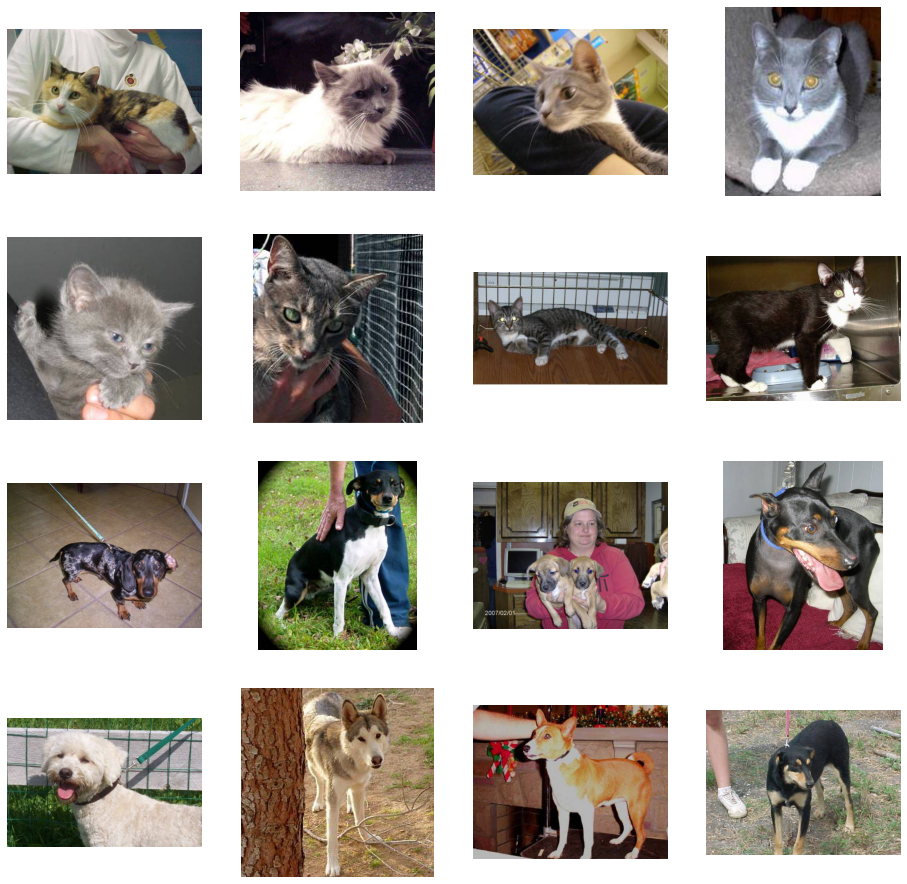

In [10]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index += 8
next_cat_pic = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pic = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_cat_pic+next_dog_pic):
  s = plt.subplot(nrows, ncols, i+1)
  s.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [0]:
# Building The Model

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
model = keras.models.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid'),
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
from tensorflow.keras.optimizers import RMSprop

In [0]:
model.compile(optimizer = RMSprop(lr = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
              )

In [0]:
# Setting up the DataGenerators

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary',
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary',
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 2,
)

Epoch 1/15
100/100 - 8s - loss: 0.7946 - accuracy: 0.5590 - val_loss: 0.6447 - val_accuracy: 0.5620
Epoch 2/15
100/100 - 7s - loss: 0.6225 - accuracy: 0.6785 - val_loss: 0.6719 - val_accuracy: 0.6660
Epoch 3/15
100/100 - 8s - loss: 0.5528 - accuracy: 0.7265 - val_loss: 0.5653 - val_accuracy: 0.6970
Epoch 4/15
100/100 - 7s - loss: 0.4618 - accuracy: 0.7880 - val_loss: 0.5711 - val_accuracy: 0.7120
Epoch 5/15
100/100 - 8s - loss: 0.3833 - accuracy: 0.8270 - val_loss: 0.7475 - val_accuracy: 0.6510
Epoch 6/15
100/100 - 7s - loss: 0.2933 - accuracy: 0.8740 - val_loss: 0.7739 - val_accuracy: 0.7010
Epoch 7/15
100/100 - 7s - loss: 0.2266 - accuracy: 0.9095 - val_loss: 0.8168 - val_accuracy: 0.7120
Epoch 8/15
100/100 - 7s - loss: 0.1453 - accuracy: 0.9450 - val_loss: 1.0324 - val_accuracy: 0.6870
Epoch 9/15
100/100 - 7s - loss: 0.1074 - accuracy: 0.9615 - val_loss: 1.1398 - val_accuracy: 0.7230
Epoch 10/15
100/100 - 7s - loss: 0.0860 - accuracy: 0.9625 - val_loss: 1.3999 - val_accuracy: 0.6970

In [0]:
# Evaluating The Model

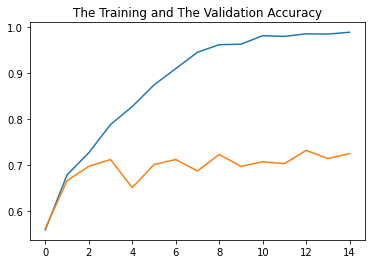

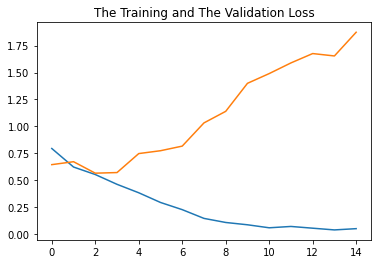

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('The Training and The Validation Accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('The Training and The Validation Loss')
plt.show()